(fmri-chapter)=
# Functional MRI

## Objectives

[Functional magnetic resonance imaging](https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging)
is an `imaging modality` that **indirectly** measures `brain activity`. `fMRI` acquires `images` of the `brain` in action in relation to different `experimental conditions`, having been designed to isolate specific `cognitive processes`. `fMRI` therefore makes it possible to `map` the `functional organization` of the `brain`, in different `cognitive contexts`.

```{figure} ../../../static/neuroscience/fmri.jpg
---
width: 600px
name: fmri-fig
---
`fMRI images` make it possible to observe `cerebral activation`, taken from [wikipedia](https://fr.wikipedia.org/wiki/Imagerie_par_r%C3%A9sonance_magn%C3%A9tique_fonctionnelle#/media/Fichier:Researcher-test.jpg).
```
The specific `objectives` of this part of the course are:
- Understand the **physical** and **physiological** principles of the `fMRI signal`.
- Understand the `model` of the **haemodynamic response**, invariant over time, which makes it possible to `estimate` the level of `activation` in `response` to various `experimental paradigms`.
- Know the main stages of **pre-processing** of `fMRI data`, namely **registration**, **spatial smoothing** and **filtering of factors of non-interest**. These steps are necessary in order to reduce `noise` in the `fMRI signal`, which does not reflect `neuronal activity`.
- Know the principle of generating an **activation map**, which, using `statistical models`, makes it possible to test hypotheses on the `functional organization` of the `brain`.

## Physical and physiological principles

### 3D images + time

|               |   `structural MRI`     | `functional MRI (T2*)`  |
| ------------- |:-------------:| -----:|
| `Study objective`      | **Anatomy, structures and properties of tissues** | **functional organization**|
| `Dimensions`     | 1 volume - **3D**   |  multiple `volumes` over `time` - **4D** |
| `Acquisition duration` | multiple minutes |  seconds |


`fMRI images` are like a `movie` of the `brain` in action. They are composed of a **series of 3D volumes** which follow one another at a given `frequency`, rather than a `single volume` as was the case in `structural MRI`. We then speak of **4D** or **3D+t** `images` since the `spatial dimensions` (`x`, `y`, `z`) are extended by the `dimension` of time `t`. We could, for example, acquire `1` `brain volume` every `2 seconds`, for `6 minutes`, which would result in an `fMRI` `dataset` consisting of `180 3D brain volumes`.

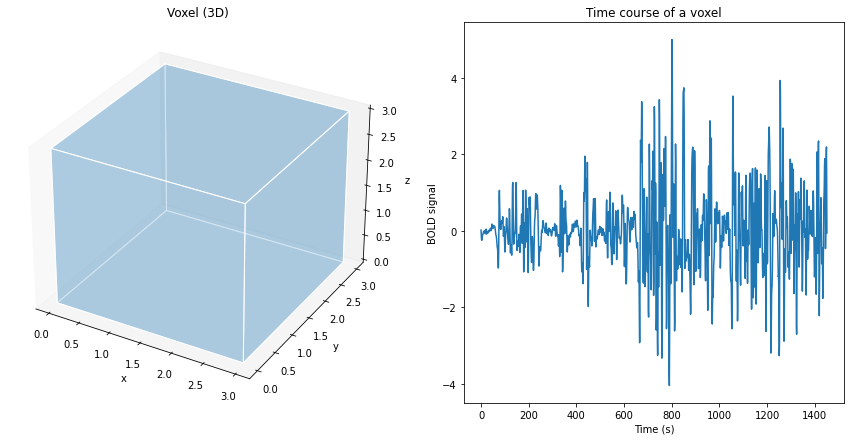

In [5]:
# Import required libraries
import pandas as pd
import nilearn
import numpy as np
from nilearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Get a functional MRI from one participant
haxby_dataset = datasets.fetch_haxby()
haxby_func_filename = haxby_dataset.func[0]

# Initialize the masker
brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

# Apply the masker
brain_time_series = brain_masker.fit_transform(haxby_func_filename,
                                               confounds=None)
# Functions for the visualization of 3D voxels
def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

# Initialization of the figure
fig = plt.figure(figsize=(15,7))

# Visualize a voxel
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.grid(False)
colors = np.array([[['#1f77b430']*1]*1]*1)
colors = explode(colors)
filled = explode(np.ones((1, 1, 1)))
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

x[1::2, :, :] += 1
y[:, 1::2, :] += 1
z[:, :, 1::2] += 1

ax1.voxels(x, y, z, filled, facecolors=colors, edgecolors='white', shade=False)
plt.title("Voxel (3D)")

# add time series
# random voxels
voxel = 1
ax = fig.add_subplot(1, 2, 2)
ax.plot(brain_time_series[:, voxel])
ax.set_title("Time course of a voxel")

plt.xlabel("Time (s)", fontsize = 10)
plt.ylabel("BOLD signal", fontsize= 10)

from myst_nb import glue
glue("voxel-timeseries-fig", fig, display=False)

```{glue:figure} voxel-timeseries-fig
:figwidth: 800px
:name: "voxel-timeseries-fig"
Illustration of a `volume element` (`voxel`), of size `3 mm x 3 mm x 3 mm`, and the associated `fMRI time course`.
```
The `volume` of the `brain` (`3D`) is formed by several thousand `voxels`, which are small `volume` units (`3D`) having a `coordinate` in `space` **x, y, z**. In `fMRI`, for each `voxel` in the `brain`, we have several `measurement points` of `activity` over `time`, which forms what is called a **time series** or **time course**. Typically, a few `tens` to `hundreds` of `measurement points` describe the `time series`. These `measurement points` are separated by a `time interval`, which can vary from `milliseconds` to `seconds`. These characteristics represent a good compromise between `spatial` and `temporal resolution`. As we will see later, the `time series` **indirectly** reflects changes in `neural activity` over `time`. Much of the work in `functional MRI` consists of analyzing these `time series`.



```{admonition} Trade-off between spatial vs temporal resolution in fMRI
:class: tip
:name: resolution

When choosing an `fMRI` `sequence`, we are often led to favor `temporal` vs. `spatial resolution`. For example, we can take `images` of the `whole brain` in `700 ms` with a spatial resolution of 3 x 3 x 3 mm$^3$, or acquire the same `image` with a `spatial resolution` of 2 x 2 x 2 mm$^3$ , but this time in `1500 ms`. There is no one choice of `parameter` that is better than another, but the researcher must decide whether `spatial` or `temporal resolution` is more important for their research questions.
```
(neurovascular-coupling-fmri-section)=
### Neurovascular coupling

```{figure} ../../../static/neuroscience/neurovascular-fig.jpg
---
width: 600px
name: neurovascular-fig
---
**Summary of neuro-glial-vascular architecture**. (a) `Astrocytes` wrap around `synapses`, and have `projections` to the `surface` of `microcapillaries`. (b) `Astrocytes` establish exclusive `anatomical` domains, which minimally overlap with those of their `astrocyte` neighbors. (c) Diagram representing the `morphology` of a `glial cell`, with a `body` connected to a tree structure. (d) `Neural micro-circuit`. (e) `cerebral microvasculature`. (f) illustration of `neural microcircuit` size and `vasculature`. (g) percentage of `volume occupancy` in `circuit space`. Figure taken from the article by {cite:p}`zisis_architecture_2021`, licensed under CC-BY-NC-ND.
```

The link between `neuronal activity` and `fMRI signal` is based on the phenomenon of **neurovascular coupling**, and more specifically the `coupling` between the `post-synaptic activity` of `neurons` and `blood micro-capillaries`. The production of `neurotransmitters` in the `synaptic cleft` triggers a series of `chemical reactions` in the surrounding `glia cells`. When `neuronal activity` increases, the accompanying `chemical reactions` lead to a **metabolic demand** for `nutrients` and ultimately the `extraction` of `oxygen` in the `micro-capillaries` locally. The following events then occur:
  * increased `volume` of `capillaries`;
  * increased `blood flow`;
  * increase the delivery of `oxygen` (`oxyhaemoglobin`) to `populations` of `active neurons`.

 The increase in `oxygen extraction` therefore paradoxically leads to a local increase in the `concentration` of **oxyhemoglobin** (`oxygenated blood`) compared to the concentration of **deoxyhemoglobin** (`deoxygenated blood`) locally, which can be detected using `fMRI`. The first `quantitative model` of `neurovascular coupling` (known as the `“balloon model”`) was proposed by {cite:p}`buxton_dynamics_1998`.


### BOLD signal
```{figure} ../../../static/neuroscience/hemoglobine-fig.jpg
---
width: 600px
name: hemoglobine-fig
---
Illustration of the transport of `oxygen` by `hemoglobin` in the `blood`. Image by [ShadeDesign](https://www.shutterstock.com/g/ShadeDesign) available at [shutterstock](https://www.shutterstock.com/image-illustration/vector-science-medical-icon-blood-hemoglobin-1472480087) ID `1472480087`, used under standard shutterstock license.
```

What is the origin of the **BOLD signal**? `Hemoglobin` exists in two states, `oxygenated` (`oxygen carrier`) and `deoxygenated` (`non-oxygen carrier`). The presence of `oxygen` modifies the `electromagnetic properties` of this `molecule`:
- **Oxyhemoglobin** is **diamagnetic**
- **Deoxyhemoglobin** is **paramagnetic**

What this means is that when subjected to `electromagnetic pulses`, these two `molecules` behave very differently. `Deoxyhemoglobin` will create `inhomogeneities` in the `magnetic field`, whereas `oxyhemoglobin` has no effect on this same `field`. $T_2^*$ weighted `MRI sequences` are very `sensitive` to such `inhomogeneities`. The `deoxyhemoglobin` therefore `distorts` the `magnetic field` $B_O$ induced by the `magnet`, which causes the `relaxation time` $T_2^*$ to be `faster`. The `images` acquired by `fMRI` therefore use a $T_2^*$ `contrast`, and this has the effect of `amplifying` the signal when the `blood` becomes more `oxygenated` in `response` to an increase in `neuronal activity`. For this reason, the `signal` used in `fMRI` is called `BOLD signal`, for _Blood oxygenation level-dependent_, or `signal dependent on blood oxygenation`.

| | `Deoxyhemoglobin` | `Oxyhemoglobin` |
| ------------- |:-------------:| -----:|
|`Electromagnetic properties` | `Paramagnetic` | `Diamagnetic`|
| Impact on the `BOLD signal` | **Reduces** the `BOLD signal` | **Increases** the `BOLD signal`|
| $T_2^*$ | Decreasing more **rapidly** | Decreasing more **slowly** |
| Effect on `field` | **Added inhomogeneities/distortions** | **No inhomogeneities** |


```{admonition} Attention!
:class: caution attention
:name: neurovascular-warning

The `BOLD signal` in `fMRI` is an **indirect measurement** of `neuronal activity`. Indeed, this `modality` does **not directly** measure the `activity` of `neurons`, but rather the `vascular consequences` of the `metabolic demand` associated with `neuronal activity`. This **neurovascular coupling** relationship is very complex, involving many different metabolites and mechanisms.
```

### Hemodynamic response function

#### Short impulse response

/Users/peerherholz/anaconda3/envs/ml-dl-synage/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


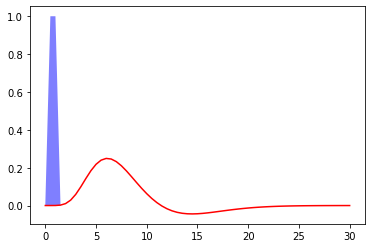

In [2]:
# To get an impulse response, we simulate a single event
# occurring at time t=0, with duration 1s.
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

# Now we plot the hrf
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))

# obtain the signal of interest by convolution
signal, name = compute_regressor(
    exp_condition, 'glover', frame_times, con_id='main',
    oversampling=16)

# plot this
plt.fill(frame_times, stim, 'b', alpha=.5, label='stimulus')
plt.plot(frame_times, signal.T[0], 'r', label=name[0])

# Glue the figure
from myst_nb import glue
glue("hrf-fig", fig, display=False)

```{glue:figure} hrf-fig
:figwidth: 800px
:name: "hrf-fig"
`Hemodynamic response` to a `unit pulse` of `1 second duration`, following the `model` proposed by Glover et al. (1999) {cite:p}`Glover1999-cb`. The code to generate this figure is adapted from a [Nilearn tutorial](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py), and the figure is licensed under CC-BY.
```
The following figure shows the expected `hemodynamic response` following a `finite activation pulse` at `time 0`, and of duration `1 second`. The `response` to this type of `stimulus` visualizes the most widely used `hemodynamic response`, describing the sustained relationship between `neural activity` (blue) and `BOLD signal` (red), as a `function of time`. The `'x' axis` represents `time`, in `seconds`, and the `'y' axis` the `brain signal`, expressed as `percentage change` from a `baseline`. Important features of the `hemodynamic response function` are:

- **temporal resolution**: this is a `slow response`, which lasts between **15 to 20 seconds** depending on the `stimulus`
- **the time before reaching the maximum amplitude**: from **4 to 6 seconds**
- **Post-stimulation trough (*Undershoot* in English)**: decreases from the `maximum amplitude` until it is below the `baseline`.
- **Return to baseline**: The `function` returns to the `level` before the `stimulation` after approximately **15 to 20** `seconds`
- **Maximum amplitude**: The order of the `relative change` of the `BOLD signal` reaches around **5%** for `sensory stimulations`, while it is more like **0.1 to 0.5% ** for other `cognitive paradigms`

```{admonition} Attention!
:class: tip
:name: model-tip fit

The above `hemodynamic response model` is very `rigid` and may prove to be an `invalid assumption` for some `populations`, especially if the `neurovascular coupling` is different from the original study by {cite:p}`glover_deconvolution_1999`. This is probably the case, for example, in the `elderly` or in `individuals with cardiovascular diseases`. The `hemodynamic response function` can also vary from one `region` of the `brain` to another. It is possible to use `models` of the `hemodynamic response` which are more flexible and allow, for example, to modify the `time` of the `peak` of the `response`.
```

#### The Brain (BOLD) as a System
```{figure} ../../../static/neuroscience/system_fig.png
---
width: 400px
name: system-fig
---
A `system` takes an `input` `time course` and associates it with an `output` `time course`. Figure licensed under CC-BY.
```

The process that transforms `neuronal activity` into a `BOLD signal` can be formalized within the general framework of `systems theory`. More specifically, the `hemodynamic response function` of the {numref}`hrf-fig` is generally `approximated` as a `linear` and `time-invariant system`. This `approximation` underlies the inferences we make about the `functional organization` of the `brain`: we use it to `estimate` the `response` to a given `task` or `condition`. The `hemodynamic response function` of the {numref}`hrf-fig` relates to a `simple experimental context`: a `short` and `isolated stimulation`. In reality, **experimental paradigms are much more complex**: they `repeatedly alternate` between `different experimental conditions`/`stimuli` (in `blocks`, `randomly` or in a `specific order`). In addition, they often involve more than one `stimulation` close in `time`, or/and `stimuli` that extend over `several milliseconds` or `seconds`. What then happens to the `hemodynamic response function`? A key property of a `linear system` is to be `additive`, ie the `response` to a `long stimulation` can be `decomposed` like the `superposition` of `responses` to `shorter stimulations`. Another key assumption is **time invariance**, which tells us that the `system` `response` will not vary if we perform the same `short stimulation` at different `times`. When **combining** the `linearity assumption` with `time invariance`, it is possible to predict the `response` to any `series` of `complex stimuli` from the `response` to a `single short stimulus`, as shown in {refnum}`hrf-fig`. The study by Logothetis et al. (2001) {cite:p} `Logothetis2001-lt` was the first to demonstrate in monkeys that this assumption of `linearity` and `invariance` seems to be fairly well respected, at least in the `visual cortex` for `simple visual stimuli` (context of the study).

```{admonition} Additivity
:class: tip
:name: additivity-tip
A `system` is said to be **additive** if the `response` to several `impulses` corresponds to the `sum of the responses` to these `impulses` taken `independently`. This `behavior is illustrated below.

```{figure} ../../../static/neuroscience/additive_system.png
---
width: 400px
name: systeme-additif-fig
---
Figure licensed under CC-BY.
```

## fMRI data pre-processing
We have discussed in previous sections various aspects of `modeling` the `hemodynamic response`. Another important point in `fMRI` is the `modeling` of `noise` and `sources of variations` that may be present in `time series`. Different **confounding factors** and **artifacts** (from the `MRI` scanner or from the scanned `participant`s themselves) can induce substantial `fluctuations` in the measured `BOLD signal`, and `confound` `inferences` made about the `neural activity` in `response` to `tasks`:

- `heart`/`pulse`,
- `artefact` linked to the `movement` of the `participant` during the `acquisition`,
- fault in the `antenna`,
- `inhomogeneities` in the `magnetic field`, in particular at the `air-tissue intersections`,
- differences between the `anatomy` of the `participant`s.

Different `modeling` strategies can be employed to reduce the influence of `confounding factors` and `artifacts`. In this section, we present an overview of three major `fMRI preprocessing` steps, which typically are applied `sequentially`. We speak of _processing chain_, or even _pipeline_ or _worflow_.

### Realignment/registration

The `registration` consists in `aligning` an `image` to a `reference image`. It is a `pre-processing` step completed before `individual statistical` and `group statistical analyses`, as these presuppose that there is a match between the `voxels` of `images` within a `participant` and between `participant`s. We have already discussed the {ref}`registration-tip>`registration in the [morphometry](morphometry) section. We will see that three types of `registration` are used in `functional MRI`.

#### Movement registration
```{figure} ../../../static/neuroscience/movement_parameters.png
---
width: 500px
name: movement-fig
---
Illustration of the `motion registration` process during an `fMRI scan`. Figure licensed under CC-BY.
```
Often, the `participant` does not maintain exactly the same `position` of the `head` in the `scanner` throughout the `acquisitions`, which can sometimes last more than an hour and/or require stops. (e.g. `yawning`, `muscle fatigue`, `blinking`, etc.). These `movements` have `non-negligible impacts` on the `BOLD signal`. They can cause `distortions` in the `signal intensity` of the picture. They imply that, from one `image` to another, the same `voxel` does not necessarily correspond to the same `cerebral structure`. As the `brain` of the same `individual` does not change `shape` or `size` through the `acquisitions`, this step uses a special case of `affine transformation`, called `rigid transformation`, comprising only `three translations` (according to `x`, `y` and `z`) and `three rotations` (according to `x`, `y` and `z`). A `reference volume` is used as the target for the `registration`, for example the `first volume` of the `series`, the `last`, or else the `average` of `all` the `volumes`. Different `movement parameters` are estimated for each `volume`, and can be represented over time as on the graph above.

```{admonition} Excessive movements
:class: tip
:name: motion-tip
The level of `movement` varies depending on the `population` studied. `Children` and `older people` tend to `move` more than `young adults`. Some researchers choose to exclude `participant`s who `moved` beyond a certain `threshold`.
```

#### BOLD registration with $T_1$
It is common to `align` the `BOLD image` with the $T_1$ `anatomical image` of the `participant`. Why? The `functional image` has a lower `spatial resolution` than the `structural image` $T_1$: we have shorter `acquisition times` to `acquire` the same `volume`. The contrast between `anatomical structures` is also much better in $T_1$. It is therefore useful to superimpose the two `images` to locate the `BOLD activations`. This `transformation` is estimated `rigidly`, like `motion`. Note that there are also `non-rigid distortions` caused by `field non-uniformities`, which can be additionally corrected.


#### Registration in stereotactic space
```{figure} ../../../static/neuroscience/registration-macaque.gif
---
width: 500px
name: registration-macaque-fig
---
Illustration of the `registration process` of a `T1 MRI` on a `stereotactic space` (here in the `macaque`). We start with an `affine transformation` (to correct the `position` of the `head` and its `size`), then `non-linear` (to adjust the `position` of the `furrows` and `subcortical structures`). Figure under CC-BY 4.0 license contributed by [Dan J Gale](https://github.com/danjgale).
```

For `inter-individual comparisons` or `group statistical analyses`, there must be a match between the `voxels` of `images` from different `individuals`. However, `brains` and `anatomical structures` can have different `sizes` and `shapes` from `individual` to `individual`. `Registration` in `stereotactic space`, also sometimes called _spatial normalization_, consists in `registering` the $T_1$ `image` in a `target standard space` defined by the chosen `atlas`, `template`, or so on, thus making the `brains` of different `individuals comparable`. This technique is identical to what is done for `morphometry` studies. The [MNI152 template](http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009) ([Montreal Neurological Institute](https://www.mcgill.ca/neuro/)) is widely used as a `standard space` in the community. The respective `transformation` combines `affine transformation` and `non-linear transformation`.


### Spatial smoothing

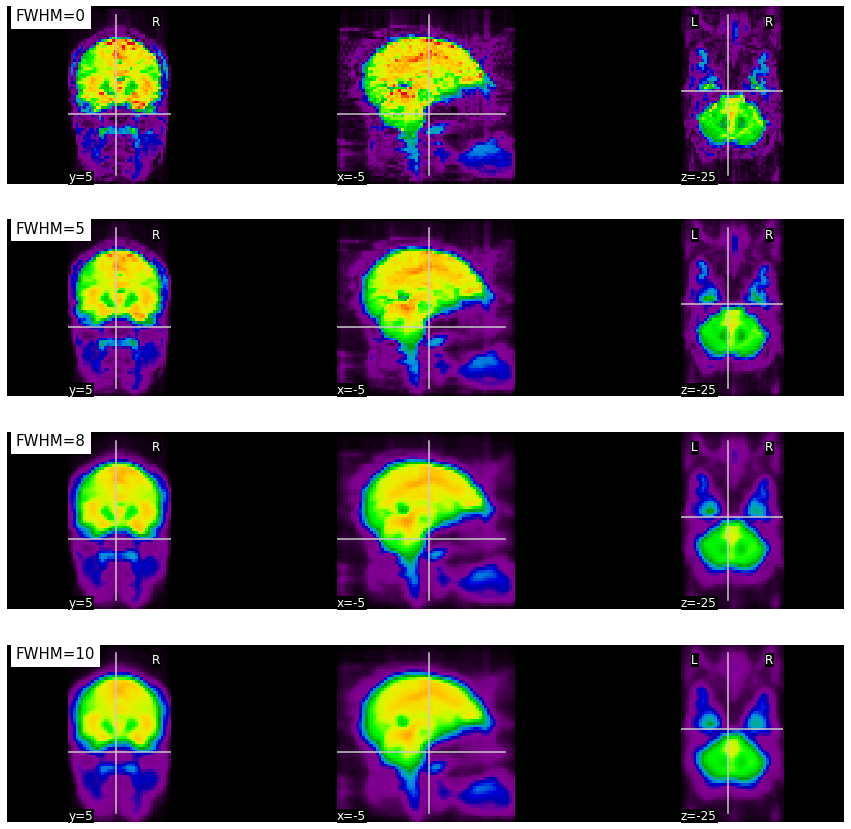

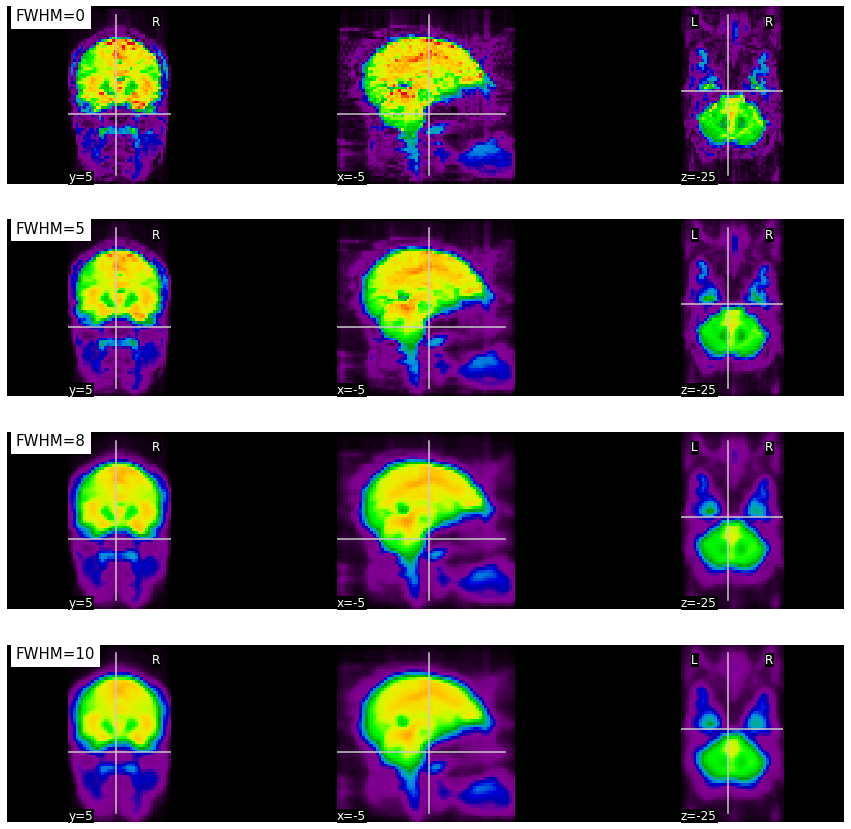

In [3]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Download a functional scan
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# Calculate mean image
from nilearn.image.image import mean_img
func_filename = haxby_dataset.func[0]
mean_haxby = mean_img(func_filename)

from nilearn.plotting import plot_epi, show

# Initialize the figure
fig = plt.figure(figsize=(15, 15))

from nilearn.plotting import plot_anat
from nilearn.image import math_img
from nilearn.input_data import NiftiMasker
from nilearn.image import smooth_img

list_fwhm = (0, 5, 8, 10)
n_fwhm = len(list_fwhm)
coords = [-5, 5, -25]

for num, fwhm in enumerate(list_fwhm):
    ax_plot = plt.subplot2grid((n_fwhm, 1), (num, 0), colspan=1)
    vol = smooth_img(mean_haxby, fwhm)
    plot_epi(vol,
              cut_coords=coords,
              axes=ax_plot,
              black_bg=True,
              title=f'FWHM={fwhm}',
              vmax=1500)

from myst_nb import glue
glue("smoothing-fmri-fig", fig, display=False)

```{glue:figure} smoothing-fmri-fig
:figwidth: 600px
:name: smoothing-fmri-fig
Illustration of the impact of `smoothing` on a `BOLD volume`.
As the ``FWHM` parameter` increases, the measure in a `voxel` represents the `average` in a `larger` and `larger` `spatial neighborhood`.
This figure is generated by python code using the [nilearn](https://nilearn.github.io/) library and the `haxby` [dataset](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_haxby.html#nilearn.datasets.fetch_haxby) (click on + to see the code). The figure is licensed under CC-BY.
```
We return here to a `preprocessing` step that we have already covered during the `VBM` section: `spatial smoothing`. The `smoothing` process is similar for `functional MRI`, but the purpose of this step is a little different. `Random thermal noise` plays a greater role in the `BOLD signal`, and can have a detrimental effect on `statistical analyses`. `Spatial smoothing` _reduces_ this `random noise`. Apart from improving the `signal-to-noise ratio`, `smoothing` also makes it possible to attenuate `registration` `imperfections` between `participant`s, by `diffusing` the `activity` in `space`. More operationally, `smoothing` consists in taking the `voxels` of the `image` and `replacing` them with a new `value` considering the `values` ​​of `neighboring voxels`. Each `neighboring voxel` is assigned a `weight` that `quantifies` its `contribution` to the new `value` assigned to a target `voxel`. The `original value` of the `target voxel` is the one that will have the greatest `weighting`, and the `values` ​​of `neighboring voxels` will be `weighted` according to the `proximity` maintained with the `target voxel`. So `smoothing` replaces the `value` associated with each `voxel` with a `weighted average` of its `neighbors`. As it is a `weighted average`, the `original value` of the `voxel` is the one that will have the greatest `weight`, but the `values` ​​of the `voxels` located directly around it will also affect it greatly. The `FWHM` parameter (*full width at half maximum*) controls the `scale` of this `smoothing` (larger or smaller). It determines the `spread` of `neighboring voxels` that will participate in the new `value` of a `target voxel`. From a mathematical point of view, the `FWHM` parameter represents `half the width of the Gaussian curve`, which describes `randomly distributed noise`. A larger `FWHM` `value` underlies a more spread participation of `neighboring voxels` to the new `value` of a `target voxel` in the `image`. Several studies choose `6 mm` as the value for the `FWHM` parameter.

### Filtering out factors of no interest

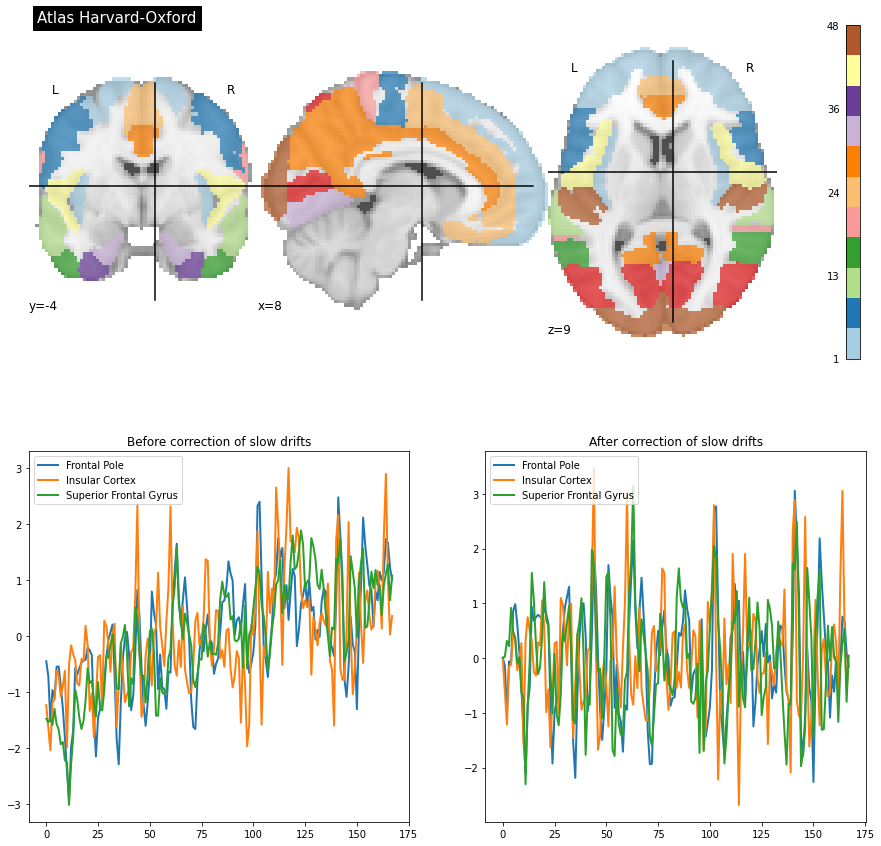

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Import a functional dataset
from nilearn import datasets
dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]

# Import an atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Initialize the figure
fig = plt.figure(figsize=(15, 15))

# Generate a time series
masker = NiftiLabelsMasker(atlas.maps,
                           labels=atlas.labels,
                           standardize=True)
masker.fit(func_filename)
signals = masker.transform(func_filename)

# Plot the atlas
from nilearn.plotting import plot_roi
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plot_roi(atlas.maps,
    axes=ax,
    title="Atlas Harvard-Oxford",
    cut_coords=(8, -4, 9),
    colorbar=True,
    cmap='Paired')

# Plot the time series
import matplotlib.pyplot as plt
ax = plt.subplot2grid((2, 2), (1, 0), colspan=1)
for label_idx in range(3):
    ax.plot(signals[:, label_idx],
            linewidth=2,
            label=atlas.labels[label_idx + 1])  # 0 is background
ax.legend(loc=2)
ax.set_title("Before correction of slow drifts")

# Generates time series after correcting for slow drifts
masker = NiftiLabelsMasker(atlas.maps,
                           high_pass=0.01,
                           t_r=4,
                           labels=atlas.labels,
                           standardize=True)
masker.fit(func_filename)
signals = masker.transform(func_filename)

# Plot the time series
ax = plt.subplot2grid((2, 2), (1, 1), colspan=1)
for label_idx in range(3):
    ax.plot(signals[:, label_idx],
            linewidth=2,
            label=atlas.labels[label_idx + 1])  # 0 is background
ax.legend(loc=2)
ax.set_title("After correction of slow drifts")

from myst_nb import glue
glue("detrending-fmri-fig", fig, display=False)

```{glue:figure} detrending-fmri-fig
:figwidth: 600px
:name: detrending-fmri-fig
We extract the `time series` associated with the `Harvard-Oxford` `atlas` before (on the left) and after (on the right) `regression` of the `slow drifts`.
This figure is adapted from a tutorial from [nilearn](https://nilearn.github.io/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html#sphx-glr-auto-examples-06-manipulating-images-plot-nifti-labels-simple-py) from a `development_fmri` [dataset](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_development_fmri.html#nilearn.datasets.fetch_development_fmri) (click on + to see the code). The figure is licensed under CC-BY.
```

The last `pre-processing` step that will be addressed is that of `filtering` out `factors of non-interest`, or `confounding factors`. These `confounding factors` can have different `sources`, such as `heart`/`pulse`, `breathing`, or `movement`. They are characterized in particular by different `frequencies` of the `spectrum`, either `slower` or `faster`. `Slow drifts` are a common example of `factors of no interest`, and they are quite easily spotted in the `signal`. In this case, we can apply a `high-pass filter`, which only keeps `frequencies` `higher` than a certain `threshold` (e.g. `0.01 Hz`). Many other types of `confounders` are commonly regressed in `fMRI` - for example `motion parameters`.

## Statistical analyses

`Statistical analyzes` generally include **individual analyses** in which the `time series` are `analyzed` separately for each of the `participants` (we analyze the `effect` of the `experimental manipulations`), then **group analyses** (we `analyze` the `effect` at the `group level`), where this data is combined for multiple `participants` for `analysis`. In this section we will briefly discuss the generation of `individual statistical maps`. We will come back to the `group analyzes` and the `statistical models` used in the `chapter` on [cerebral statistical maps](statistical_maps).

### fMRI - Task-Based Experiments


Dataset created in /Users/peerherholz/nilearn_data/spm_auditory

Data absent, downloading...


Downloaded 32546816 of 34212021 bytes (95.1%,    0.5s remaining) ...done. (11 seconds, 0 min)
Extracting data from /Users/peerherholz/nilearn_data/spm_auditory/sub001/MoAEpilot.zip..... done.


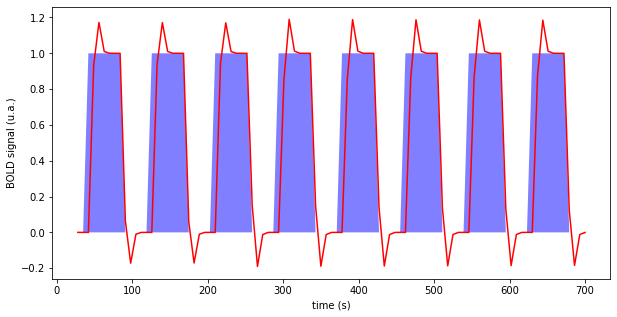

In [4]:
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load fMRI data
subject_data = fetch_spm_auditory()

fig = plt.figure(figsize=(10,5))

# load events
events = pd.read_table(subject_data['events'])
events['amplitude'] = 1
events = events[events['trial_type']=='active']
events = events.loc[:,['onset', 'duration', 'amplitude']].to_numpy().transpose()

frame_times = np.linspace(4*7, 100*7, 100-4+1)
from nilearn.glm.first_level import compute_regressor

block, name = compute_regressor(
        events, None, frame_times, con_id='main',
        oversampling=16)
block = block > 0

response, name = compute_regressor(
        events, 'glover', frame_times, con_id='main',
        oversampling=16)

plt.fill(frame_times, block, 'b', alpha=.5, label='stimulus')
plt.plot(frame_times, response, 'r', label=name)
plt.xlabel('time (s)')
plt.ylabel('BOLD signal (u.a.)')

# Glue the figure
from myst_nb import glue
glue("hrf-auditory-fig", fig, display=False)

```{glue:figure} hrf-auditory-fig
:figwidth: 500px
:name: "hrf-auditory-fig"
Illustration of a `block paradigm`, here `auditory perception`. In blue: `periods` of `audio stimulation`. In red: `predicted brain response` with the `time-invariant linear response model`, and a `unitary response` following the `model` of Glover et al. (1999) {cite:p}`Glover1999-cb`. The code to generate this figure is adapted from a [ Nilearn tutorial](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py), and the figure is licensed under CC-BY.
```

To determine whether `brain voxel` `activity` changes in `response` to `experimental manipulations`, a standard `experimental approach` is to `manipulate` the `task` the `participant` is performing in the `scanner`, for example by `alternating` different `block conditions` (`auditory stimulation`, `silence`). We then use `contrasts`, also called `subtraction analysis`, which proceed by `comparing` the `time series` of one `condition` to another `condition`, or to a `base threshold`. In a simplified way, the `analysis` consists of computing the difference of `average brain activity` between the `period` of `silence` and the `period` of `auditory stimulations`. These `contrasts` are repeated for each of the `voxels` of the `brain`, and generate a **cerebral statistical map**.

### Massive univariate regression
It is possible to `generalize` the `subtraction analysis` to account for **1) the shape of the hemodynamic response**
**2) the presence of several conditions in the same experiment**. In practice, by making an `assumption` of a `linear` and `time-invariant system`, one generates a `prediction` of the `shape` of the `response` to an `experimental condition`, as in the {numref}`hrf-auditory-fig`. A `linear regression model` is then used to `estimate` the `amplitude` of this `response`, in order to adjust the `model` as closely as possible to the `values` measured in a `voxel`. This `regression` generates an `amplitude parameter` (and runs a `significance test`) for each `voxel`. We talk about `univariate regression` because each `voxel` in the `brain` is `analyzed` `independently`. And we talk about `massive univariate regression`, because we repeat this procedure for `tens` (or even `hundreds`) of `thousands` of `voxels`!(activation-section)=

### fMRI - Activation Maps

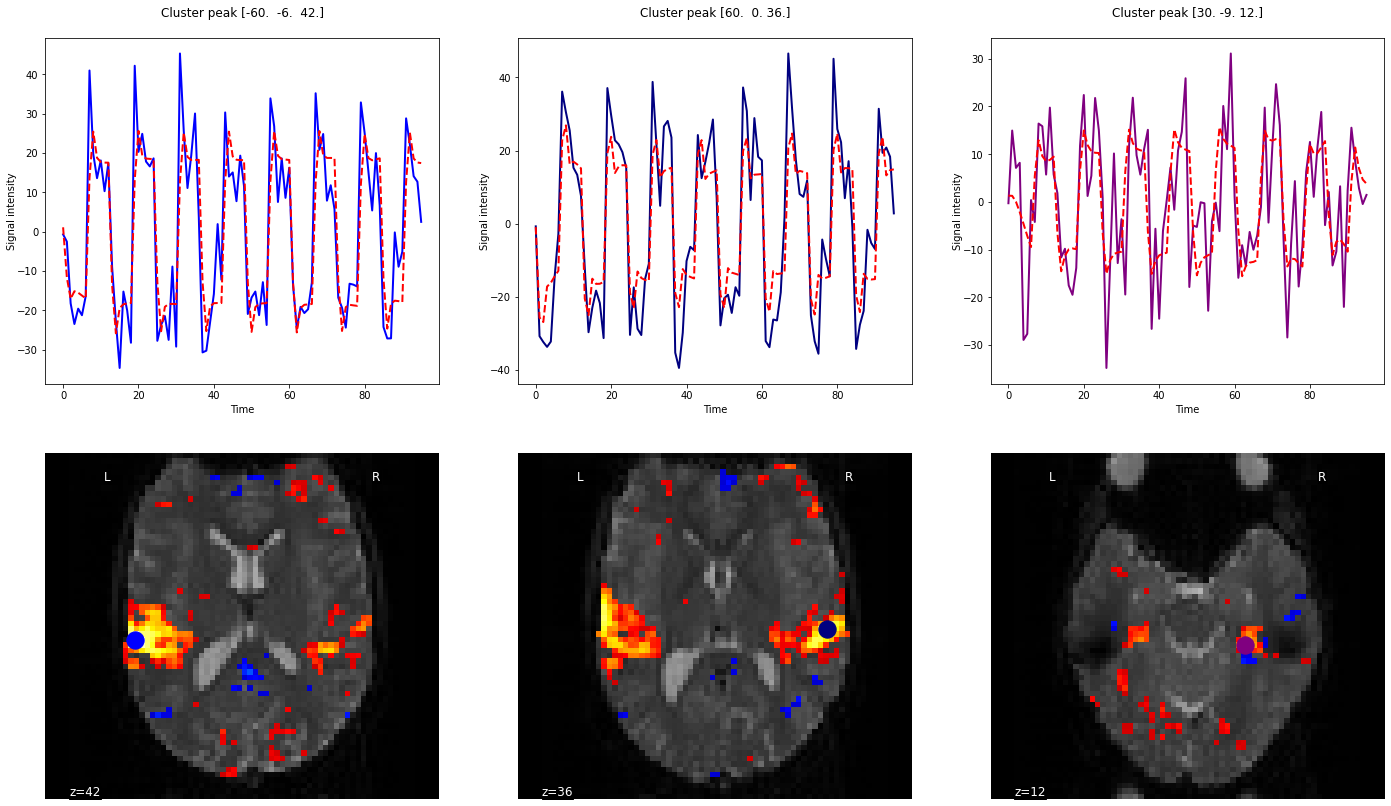

<Figure size 504x360 with 0 Axes>

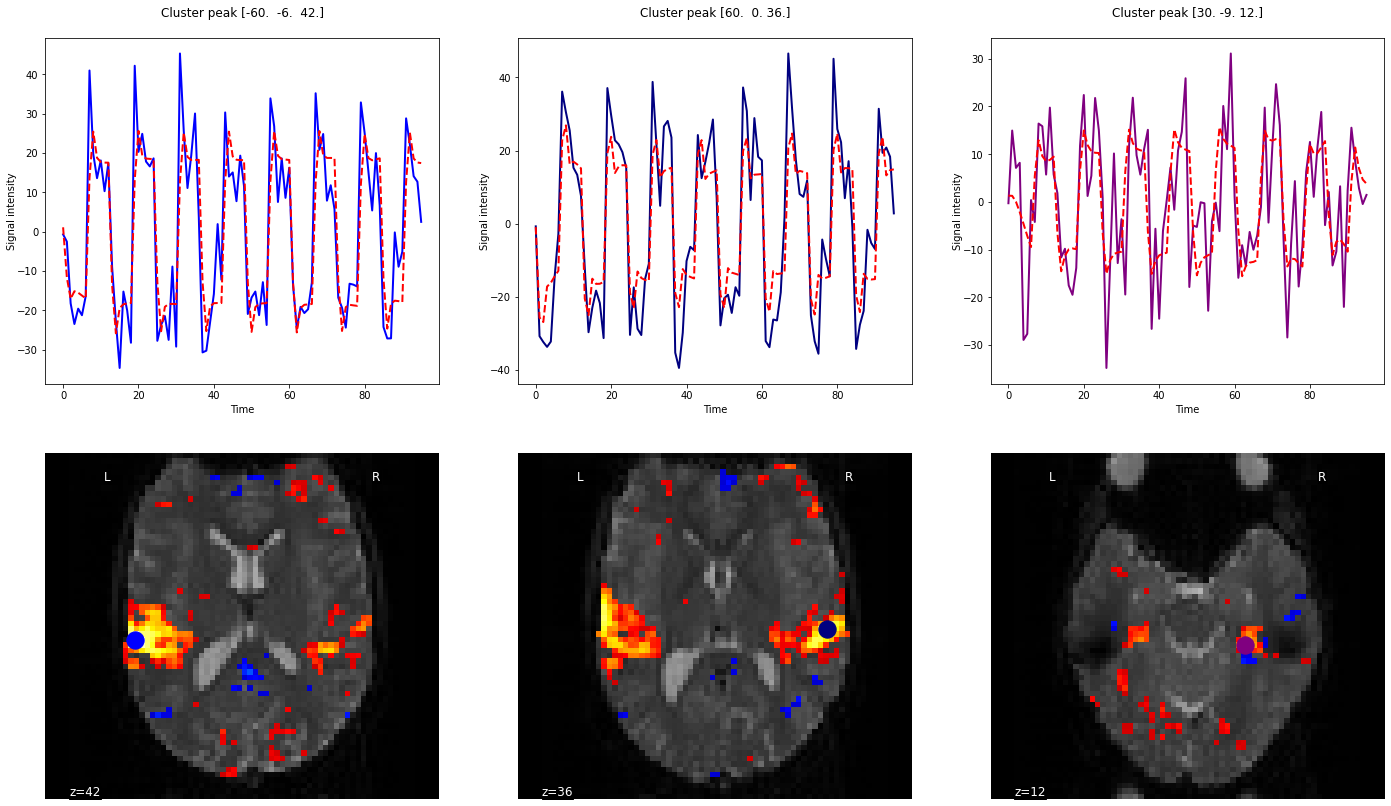

In [6]:
# Import necessary libraries
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import pandas as pd

# Initialize the figure
fig = plt.figure(figsize=(7,5))

# load fMRI data
subject_data = fetch_spm_auditory()
fmri_img = image.concat_imgs(subject_data.func)

# Make an average
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)

# Clean and smooth data
fmri_img = image.clean_img(fmri_img, high_pass=0.01, t_r=7, standardize=False)
fmri_img = image.smooth_img(fmri_img, 5.)

# load events
events = pd.read_table(subject_data['events'])

# Fit model
from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(t_r=7,
                           drift_model='cosine',
                           signal_scaling=False,
                           mask_img=mask,                           
                           minimize_memory=False)

fmri_glm = fmri_glm.fit(fmri_img, events)

# Extract activation clusters
from nilearn.reporting import get_clusters_table
from nilearn import input_data
z_map = fmri_glm.compute_contrast('active - rest')
table = get_clusters_table(z_map, stat_threshold=3.1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)

# get the 3 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1, 4), ['X', 'Y', 'Z']].values

# extract time series from each coordinate
masker = input_data.NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

# Plot figure
# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta', 'olive', 'teal']
# plot the time series and corresponding locations
from nilearn import plotting
fig1, axs1 = plt.subplots(2, 3)
for i in range(0, 3):
    # plotting time series
    axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img)
    roi_img.add_markers([coords[i]], colors[i], 300)

fig1.set_size_inches(24, 14)

# Glue the figure
from myst_nb import glue
glue("auditory-fig", fig1, display=False)

```{glue:figure} auditory-fig
:figwidth: 800px
:name: "auditory-fig"
`Activation map` for an `auditory block paradigm`. The three main `activation peaks` have been identified, and the `signal` is presented for each `peak`, superimposed with the `activity` `predicted` by the `model` based on the `auditory stimuli`. Note how the `shape` of the `response` is identical for the three selected `voxels`, but the `amplitude` of the pattern varies (`estimated` by the `regression`). The code to generate this figure is adapted from a [Nilearn tutorial](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py), and the figure is licensed under CC-BY.
```

`Activation maps` are often what are found in scientific papers in the results section. These are `maps` of the `brain` on which the `statistics` obtained are superimposed (e.g. `level of activation`, `t-test`, `p-value`). They are superimposed vis-à-vis the corresponding `voxels` or `regions`. They are often presented following the application of `thresholds` or `masks`, isolating the most `active regions`, with the average differences between the most important and/or the most `statistically significant` `conditions`. Via such `maps`, we can study the `organization` of `systems` of interest (`visual`, `motor`, `auditory`, `working memory`, etc.), but also `compare` `groups` or associate the `level of activation` with `traits` of `interest` such as `age`, `training`, etc. .

## Conclusions
Performing an `fMRI experiment` requires thinking carefully about the `conditions` of `interest` and `controls` to `isolate` relevant `cognitive processes`, but it also requires thinking about the `underlying assumptions`:
 * **neural hypotheses**: `populations` of `neurons` will `activate` in `response` to our `conditions`.
 * **neurovascular assumptions**: We assume that the `neuronal response` will be `coupled` to a `characteristic vascular response` that can be `modeled` with a `hemodynamic function`, which is `linear` and `time-invariant`.
 * **Statistical assumptions**: We assume that our `regression model` adequately captures `brain activity`, and that we correctly account for `confounding factors` and `artifacts`.

 For all these reasons, there are still important `limitations` to the interpretation that can be made based on `fMRI` results. But it is also the `non-invasive` `whole-brain` technique that has the best `spatial resolution` to date.

## References
```{bibliography}
:filter: docname in docnames
:style: plain
```

## Exercises

In the following we created a few exercises that aim to recap core aspects of this part of the course and thus should allow you to assess if you understood the main points. 

```{admonition} Exercise 4.1
:class: dropdown
Choose the right answer. `fMRI` `data` are usually...
  1. A picture of the `brain`.
  2. A dozen `images` of the `brain`.
  3. Dozens of `brain` `images`.
```

```{admonition} Exercise 4.2
:class: dropdown
What is the `BOLD signal`? (right/wrong).
  1. A very brave `signal`.
  2. A `T2*-weighted` sequence.
  3. A type of `MRI` `sequence` that measures `brain activity`.
  4. A type of `MRI` `sequence` that measures `blood oxygenation`.
```

```{admonition} Exercise 4.3
:class: dropdown
Choose the right answer. The `BOLD signal` depends on...
  1. `Local blood flow`.
  2. `Local blood volume`.
  3. The relative `deoxyhemoglobin` concentration.
  4. All of the above answers.
```

```{admonition} Exercise 4.4
:class: dropdown
(Right/wrong) The principle of `additivity` of the `hemodynamic response` is...
  1. A `mathematical model`.
  2. A basic property of `neurovascular coupling`, always verified.
  3. A common `hypothesis`, partly confirmed experimentally.
```

```{admonition} Exercise 4.5
:class: dropdown
What `phenomena` cause a change in the `signal` measured by the `BOLD`?
```

```{admonition} Exercise 4.6
:class: dropdown
In which portion of the `vascular tree` are the main changes related to local `neuronal activity` observed?
```

```{admonition} Exercise 4.7
:class: dropdown
Right/wrong?
  1. The `hemodynamic response` starts immediately after `neuronal excitation`.
  2. The `hemodynamic response` is visible `one second` after `neuronal excitation`.
  3. The `hemodynamic response` is maximal `2 seconds` after `neuronal excitation`.
  4. The `hemodynamic response` is still visible `7 seconds` after `neuronal excitation`.
  5. The `hemodynamic response` is still visible `30 seconds` after `neuronal excitation`.
```

```{admonition} Exercise 4.8
:class: dropdown
True/False/Maybe? (explain why)
  1. `Functional` and `structural` `MRI` `data` must be `realigned` to generate an `activation map`.
  2. `“Raw”` `fMRI` `data` (before pre-processing) cannot be used to generate an `activation map`.
  3. `Spatial smoothing` is important even for `individual analysis`.
```

```{admonition} Exercise 4.9
:class: dropdown
We compare `activation` for a `memory task` in the `frontal cortex` between two groups of `participants`: young `participants` and elderly `participants` (N=20 per group). Contrary to our hypotheses, no difference is found. Give three reasons that can explain this result. For each possible reason, suggest a modification to the `protocol` that would uncover a difference between the two groups.
```

```{admonition} Exercise 4.10
:class: dropdown
To answer the questions in this exercise, first read the article *High-resolution functional MRI of the human amygdala at 7 T* by Mensen et al. (published in 2013 in the journal *European Journal of radiology*, volume 82, pages 728 to 733).
It is freely available at this [address](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3629563/).
The following questions require short-answer answers.
 - What type of `participants` were recruited in this study?
 - What is the main `objective` of the study?
 - What are the `inclusion` and `exclusion criteria`?
 - What `neuroimaging` technique is used? Is it a `structural` or `functional` technique?
 - What type of `image acquisition sequence` is used? List the `parameters`.
 - Which pre-processing steps were applied?
 - What `statistical models` were applied?
 - Which figure (or table) meets the main `objective` of the study?
 - What is the main result of the study?
```